# **Pneumonia Detection**


In [2]:
# Cloud Storage
from google.cloud import storage
storage_client = storage.Client(project='Pneumonia Detection')

In [3]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import seaborn as sns
import sklearn
import os
import shutil
import cv2
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/per

# **Data Visualization and Preprocessing**

In [5]:
#Function to parse through the folders and extract the images from their folders
labels = ['PNEUMONIA', 'NORMAL']
img_size = 224
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                resized_arr_rgb_format = cv2.cvtColor(resized_arr, cv2.COLOR_BGR2RGB)
                data.append([resized_arr_rgb_format, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [6]:
#Getting the image datasets from paths of the training, test and validation dataset.
train = get_training_data('/kaggle/input/chest-xray-pneumonia/chest_xray/train')
test = get_training_data('/kaggle/input/chest-xray-pneumonia/chest_xray/test')
val = get_training_data('/kaggle/input/chest-xray-pneumonia/chest_xray/val')

/tmp/ipykernel_32/2640944502.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [7]:
#Joining the datasets to enable splitting the dataset using the 80:20 ratio
dataset = np.concatenate((train, val, test), axis=0)

In [8]:
len(dataset)

5856

In [9]:
print(dataset.shape)

(5856, 2)


In [10]:
#Function to display images in the folder in the new dataset
def plot_images_from_folder(dataset):
    # Generate 8 random indices within the range of your dataset
    random_indices = random.sample(range(0, len(dataset)), 8)
    plt.figure(figsize=[14, 24])
    for i in range(8):
        plt.subplot(6, 4, i+1)
        plt.imshow(dataset[random_indices[i]][0], cmap='gray')
        plt.axis('off')
        plt.title(dataset[random_indices[i]][1])  

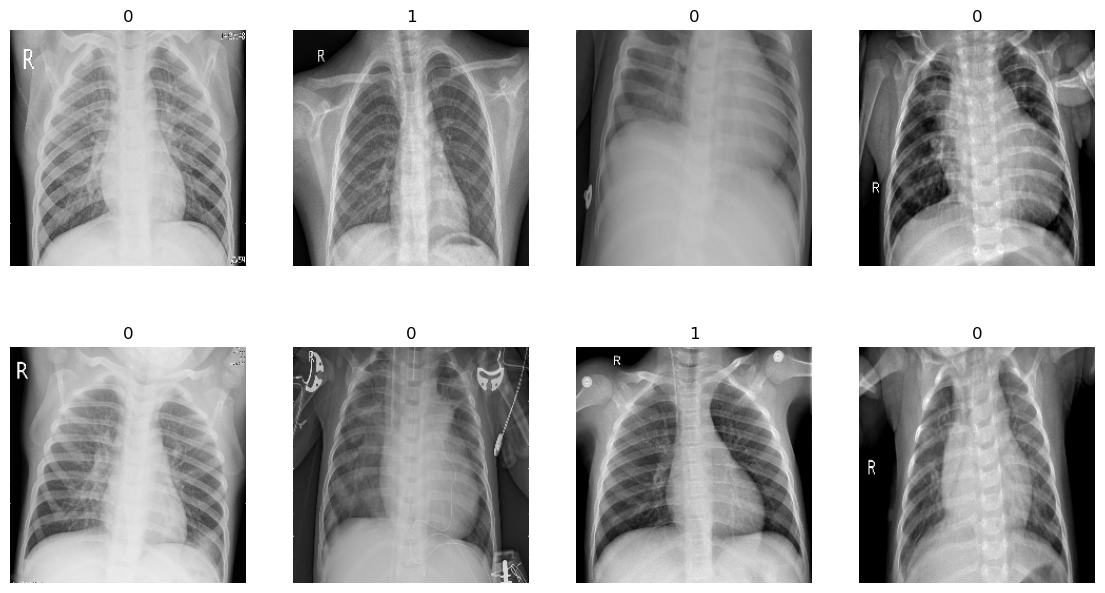

In [11]:
#Show random samples of images from the dataset
plot_images_from_folder(dataset)

In [12]:
#Split the dataset into the training and test dataset
initial_train_df, test_df = train_test_split(dataset, test_size = 0.20, random_state = 30)

In [13]:
#Split the training dataset into the training and val dataset
train_df, val_df = train_test_split(initial_train_df, test_size = 0.20, random_state = 30)

In [14]:
#Function to display the count for the label for each class
def count_labels(labels):
    extracted_labels = [data[1] for data in labels]
    print("Number of labels", len(extracted_labels))
    # Count the occurrences of each class label
    class_counts = np.bincount(extracted_labels)

    # Print the counts
    count_0 = class_counts[0]
    count_1 = class_counts[1]
    print("Count of 0:", count_0)
    print("Count of 1:", count_1)
    sns.set_style('darkgrid')
    sns.countplot(x=extracted_labels).set(title="training data")

Number of labels 3747
Count of 0: 2739
Count of 1: 1008


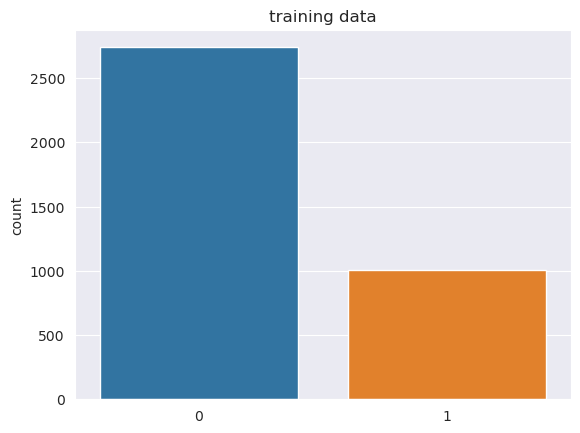

In [15]:
#Class distribution for training dataset
count_labels(train_df)

Number of labels 937
Count of 0: 698
Count of 1: 239


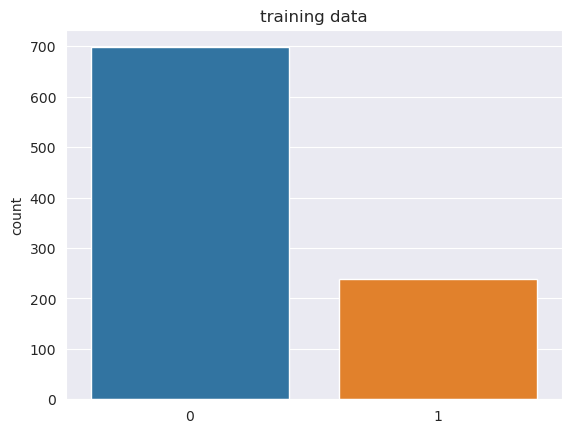

In [16]:
#Class distribution for validation dataset
count_labels(val_df)

Number of labels 1172
Count of 0: 836
Count of 1: 336


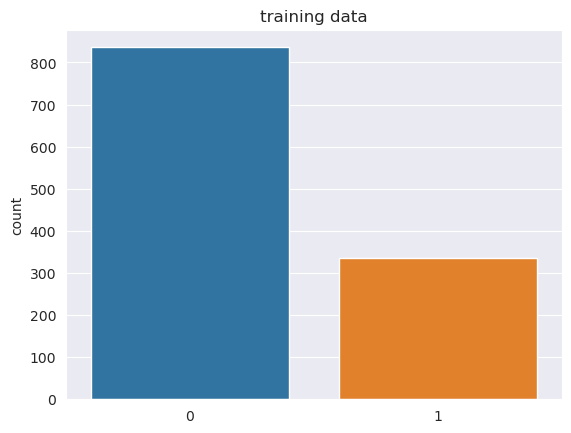

In [17]:
#Class distribution for test dataset
count_labels(test_df)

In [18]:
#Shape of training dataset
train_df.shape

(3747, 2)

In [19]:
#Shape of val dataset
val_df.shape

(937, 2)

In [20]:
#Shape of test dataset
test_df.shape

(1172, 2)

In [21]:
#Seperate the images and labels
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train_df:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test_df:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val_df:
    x_val.append(feature)
    y_val.append(label)

In [22]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [23]:
# reshape data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 3)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 3)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 3)
y_test = np.array(y_test)

In [24]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [25]:
# Define the early stopping and learning rate reduction callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5, restore_best_weights=True)
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience = 3)

# **Models** 

# RESNET50

In [26]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50

# Loading the ResNet50 model
resnet50_base_model = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
)

# Making sure the layers of the ResNet50 model are not retrained 
for layer in resnet50_base_model.layers:
    layer.trainable = False

resnet50_model = tf.keras.models.Sequential()
resnet50_model.add(resnet50_base_model)
resnet50_model.add(tf.keras.layers.Flatten())
resnet50_model.add(tf.keras.layers.BatchNormalization())
resnet50_model.add(tf.keras.layers.Dense(1024, activation='relu'))
resnet50_model.add(tf.keras.layers.Dropout(0.5))
resnet50_model.add(tf.keras.layers.Dense(512, activation='relu'))
resnet50_model.add(tf.keras.layers.Dense(256, activation='relu'))
resnet50_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

resnet50_model.summary()

resnet50_model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)



94765736/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 batch_normalization (BatchN  (None, 100352)           401408    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1024)              102761472 
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               52

In [27]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=0.00001)
resnet50_model_history = resnet50_model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=50,
    validation_data=datagen.flow(x_val, y_val),
    callbacks=[early_stopping, learning_rate_reduction]
)
print(resnet50_model)
print(next(datagen.flow(x_train, y_train)))


Epoch 1/50
118/118 [==============================] - 63s 440ms/step - loss: 0.5969 - accuracy: 0.8137 - val_loss: 0.4703 - val_accuracy: 0.7780 - lr: 0.0010
Epoch 2/50
118/118 [==============================] - 49s 411ms/step - loss: 0.3421 - accuracy: 0.8551 - val_loss: 0.3401 - val_accuracy: 0.8506 - lr: 0.0010
Epoch 3/50
118/118 [==============================] - 48s 409ms/step - loss: 0.2780 - accuracy: 0.8860 - val_loss: 0.3338 - val_accuracy: 0.8239 - lr: 0.0010
Epoch 4/50
118/118 [==============================] - 48s 407ms/step - loss: 0.2619 - accuracy: 0.8884 - val_loss: 0.2596 - val_accuracy: 0.8933 - lr: 0.0010
Epoch 5/50
118/118 [==============================] - 49s 415ms/step - loss: 0.2557 - accuracy: 0.8892 - val_loss: 0.2586 - val_accuracy: 0.8975 - lr: 0.0010
Epoch 6/50
118/118 [==============================] - 49s 413ms/step - loss: 0.2520 - accuracy: 0.8938 - val_loss: 0.2348 - val_accuracy: 0.9039 - lr: 0.0010
Epoch 7/50
118/118 [==============================] 

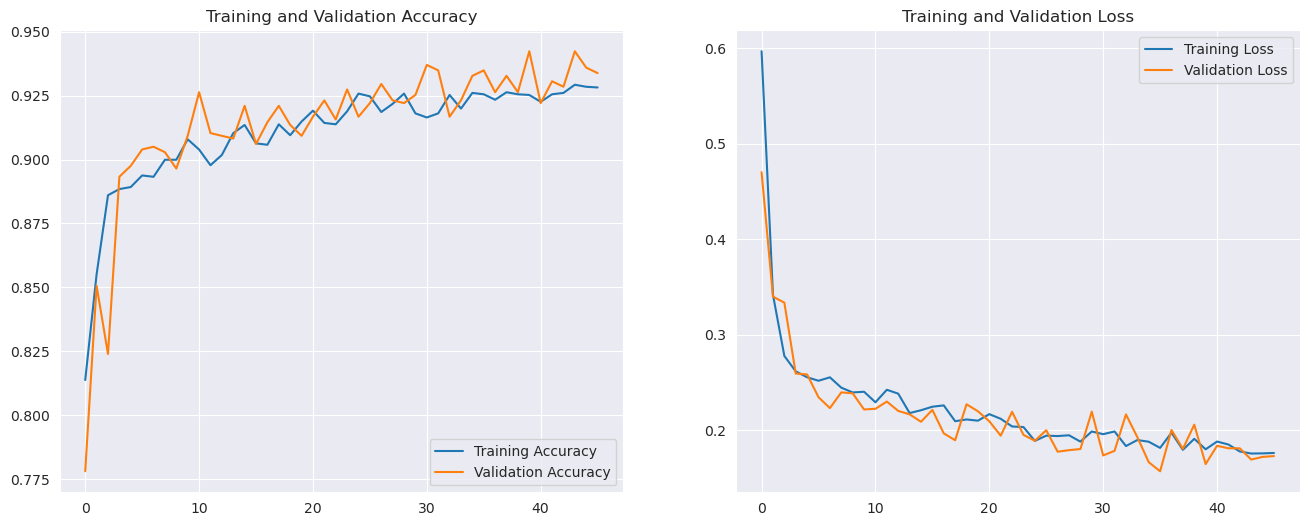

In [28]:
#Plotting the resnet50 model results

#Getting the accuracy
acc = resnet50_model_history.history['accuracy']
val_acc = resnet50_model_history.history['val_accuracy']

#Getting the losses
loss = resnet50_model_history.history['loss']
val_loss = resnet50_model_history.history['val_loss']

#No of epochs it trained
epochs_range = resnet50_model_history.epoch

#Plotting Training and Validation accuracy
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

****Performance Evaluation****

In [29]:
evaluation_result=resnet50_model.evaluate(x_test,np.array(y_test))

37/37 [==============================] - 5s 123ms/step - loss: 0.1879 - accuracy: 0.9309


In [30]:
print("Loss of the model is - " , evaluation_result[0])
print("Accuracy of the model is - " , evaluation_result[1]*100 , "%")

Loss of the model is -  0.1878821849822998
Accuracy of the model is -  93.08874011039734 %


In [31]:
resnet50_predictions = resnet50_model.predict(x_test)

37/37 [==============================] - 4s 92ms/step


In [32]:
y_pred = (resnet50_predictions> 0.5).astype("int32").flatten()

In [33]:
y_pred

array([0, 1, 1, ..., 0, 0, 0], dtype=int32)

In [34]:
y_test

array([0, 1, 1, ..., 0, 0, 0])

[[775  61]
 [ 20 316]]


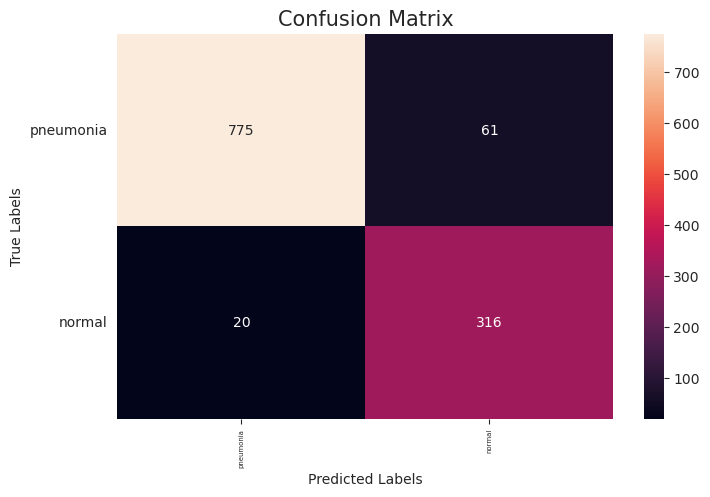

In [35]:
#Confusion matrix
Confusion_Matrix1 = confusion_matrix(y_test, y_pred)
print(Confusion_Matrix1)

import seaborn as sns

#Setting the labels
labels = ['pneumonia', 'normal']

#Plot the Confusion matrix graph
fig= plt.figure(figsize=(8, 5))
ax = plt.subplot()
sns.heatmap(Confusion_Matrix1, annot=True, ax = ax, fmt='g')
ax.set_xlabel('Predicted Labels', fontsize=10)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(labels, fontsize = 5)
ax.xaxis.tick_bottom()

ax.set_ylabel('True Labels', fontsize=10)
ax.yaxis.set_ticklabels(labels, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Confusion Matrix', fontsize=15)

plt.savefig('resnet50_ConMat24.png')
plt.show()

In [36]:
#Classification report
print(classification_report(y_test, y_pred, target_names = ['Pneumonia (0)','Normal (1)']))

               precision    recall  f1-score   support

Pneumonia (0)       0.97      0.93      0.95       836
   Normal (1)       0.84      0.94      0.89       336

     accuracy                           0.93      1172
    macro avg       0.91      0.93      0.92      1172
 weighted avg       0.94      0.93      0.93      1172



In [37]:
#Accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % (accuracy*100))

Accuracy: 93.088737


In [38]:
#Precision
precision = precision_score(y_test, y_pred)
print('Precision: %f' % (precision*100))

Precision: 83.819629


In [39]:
# Recall
recall = recall_score(y_test, y_pred, pos_label=1)
print('Recall: %f' % (recall*100))

Recall: 94.047619


In [40]:
#F1-score
F1_score = f1_score(y_test, y_pred)
print('F1_score: %f' % (F1_score*100))

F1_score: 88.639551


In [41]:
#Specificity 
specificity = recall_score(y_test, y_pred, pos_label=0)
print('Specificity: %f' % (specificity*100))

Specificity: 92.703349


In [42]:
#Save the model
resnet50_model.save("resnet50_model.h5")

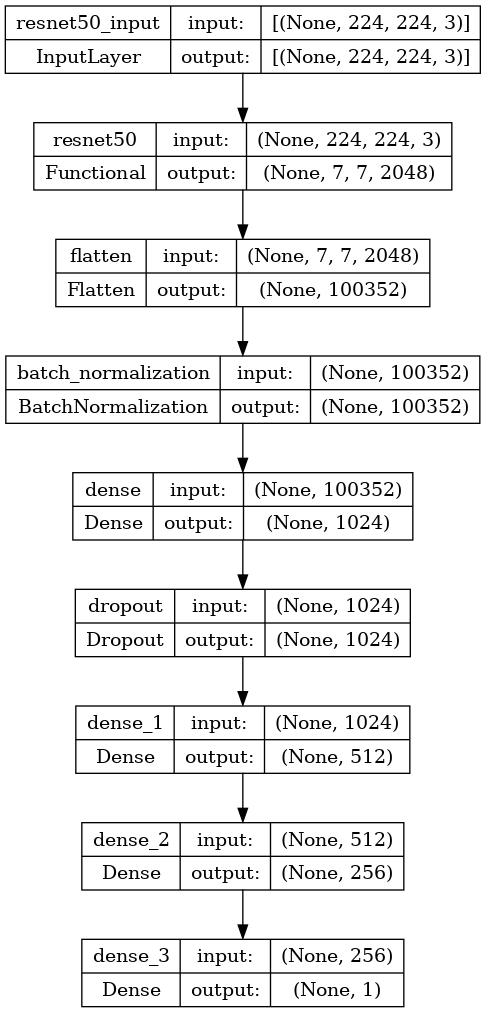

In [43]:
from tensorflow.keras.utils import plot_model

# Generate the plot
plot_model(resnet50_model, to_file='resnet50_model_architecture.png', show_shapes=True, show_layer_names=True)



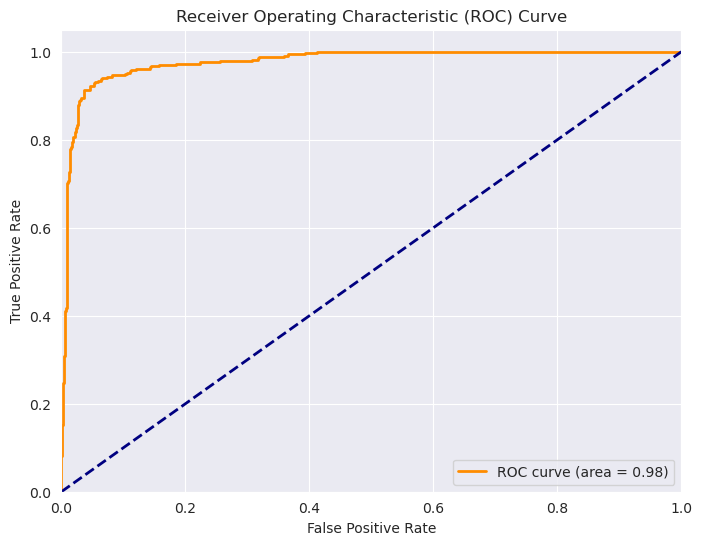

In [44]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, resnet50_predictions)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


1/1 [==============================] - 2s 2s/step


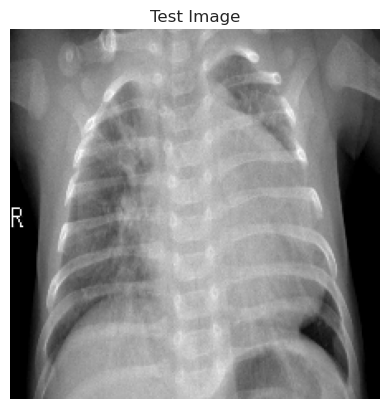

The predicted label is: Pneumonia


In [45]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

from tensorflow.keras.applications import ResNet50

# Load the saved model
from tensorflow import keras
model = keras.models.load_model('/kaggle/working/resnet50_model.h5')
import numpy as np

# Assuming 'model' is already defined

image_path = r'/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person111_bacteria_537.jpeg'
image = load_img(image_path, target_size=(224, 224))
img = np.array(image) / 255.0
img = img.reshape(1, 224, 224, 3)

prediction = model.predict(img)
predicted_class = int(round(prediction[0][0]))  # Assuming 1 is for "Normal" and 0 is for "Pneumonia"

label_dict = {0: "Pneumonia", 1: "Normal"}
predicted_label = label_dict[predicted_class]
import matplotlib.pyplot as plt

# Plot the image
plt.imshow(image)
plt.axis('off')
plt.title('Test Image')
plt.show()
print(f"The predicted label is: {predicted_label}")

1/1 [==============================] - 1s 936ms/step


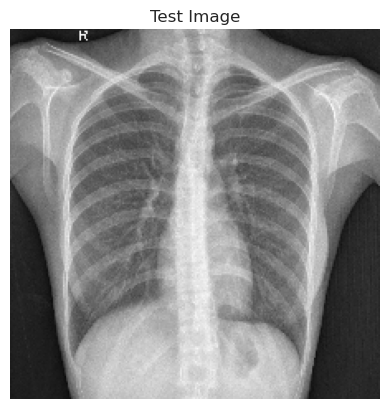

The predicted label is: Normal


In [46]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

from tensorflow.keras.applications import ResNet50

# Load the saved model
from tensorflow import keras
model = keras.models.load_model('/kaggle/working/resnet50_model.h5')
import numpy as np

# Assuming 'model' is already defined

image_path = r'/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0035-0001.jpeg'
image = load_img(image_path, target_size=(224, 224))
img = np.array(image) / 255.0
img = img.reshape(1, 224, 224, 3)

prediction = model.predict(img)
predicted_class = int(round(prediction[0][0]))  # Assuming 1 is for "Normal" and 0 is for "Pneumonia"

label_dict = {0: "Pneumonia", 1: "Normal"}
predicted_label = label_dict[predicted_class]
# Plot the image
plt.imshow(image)
plt.axis('off')
plt.title('Test Image')
plt.show()
print(f"The predicted label is: {predicted_label}")

# Densenet201

In [47]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201

# Loading the DenseNet201 model
densenet201_base_model = DenseNet201(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
)

# Making sure the layers of the DenseNet201 model are not retrained 
for layer in densenet201_base_model.layers:
    layer.trainable = False

# Building the model
densenet201_model = tf.keras.models.Sequential()
densenet201_model.add(densenet201_base_model)
densenet201_model.add(tf.keras.layers.Flatten())
densenet201_model.add(tf.keras.layers.BatchNormalization())
densenet201_model.add(tf.keras.layers.Dense(1024, activation='relu'))
densenet201_model.add(tf.keras.layers.Dropout(0.5))
# Adding two more layers as requested
densenet201_model.add(tf.keras.layers.Dense(512, activation='relu'))
densenet201_model.add(tf.keras.layers.Dense(256, activation='relu'))
densenet201_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

densenet201_model.summary()

densenet201_model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)


74836368/74836368 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 flatten_1 (Flatten)         (None, 94080)             0         
                                                                 
 batch_normalization_1 (Batc  (None, 94080)            376320    
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 1024)              96338944  
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               

In [48]:
# Train the densenet201 model with early stopping
densenet201_model_history = densenet201_model.fit(
    datagen.flow(x_train,y_train, batch_size = 32),
    epochs=50,
    validation_data=datagen.flow(x_val, y_val),
    callbacks=[early_stopping, learning_rate_reduction])

Epoch 1/50
118/118 [==============================] - 73s 489ms/step - loss: 0.7703 - accuracy: 0.8764 - val_loss: 0.2665 - val_accuracy: 0.8997 - lr: 0.0010
Epoch 2/50
118/118 [==============================] - 50s 424ms/step - loss: 0.2936 - accuracy: 0.9159 - val_loss: 0.1699 - val_accuracy: 0.9392 - lr: 0.0010
Epoch 3/50
118/118 [==============================] - 50s 420ms/step - loss: 0.1990 - accuracy: 0.9314 - val_loss: 0.1576 - val_accuracy: 0.9349 - lr: 0.0010
Epoch 4/50
118/118 [==============================] - 48s 409ms/step - loss: 0.1585 - accuracy: 0.9429 - val_loss: 0.1856 - val_accuracy: 0.9264 - lr: 0.0010
Epoch 5/50
118/118 [==============================] - 50s 421ms/step - loss: 0.1463 - accuracy: 0.9477 - val_loss: 0.1207 - val_accuracy: 0.9520 - lr: 0.0010
Epoch 6/50
118/118 [==============================] - 49s 416ms/step - loss: 0.1278 - accuracy: 0.9517 - val_loss: 0.1159 - val_accuracy: 0.9626 - lr: 0.0010
Epoch 7/50
118/118 [==============================] 

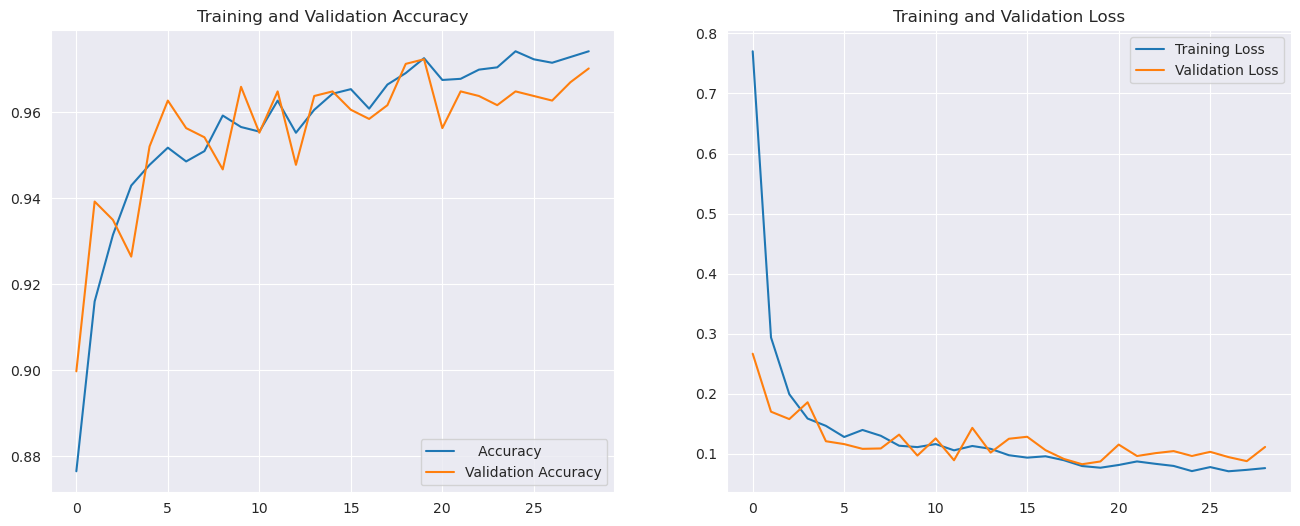

In [49]:
#Plotting the densenet201 model results

#Getting the accuracy
acc = densenet201_model_history.history['accuracy']
val_acc = densenet201_model_history.history['val_accuracy']

#Getting the losses
loss = densenet201_model_history.history['loss']
val_loss = densenet201_model_history.history['val_loss']

#No of epochs it trained
epochs_range = densenet201_model_history.epoch

#Plotting Training and Validation accuracy
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='   Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [50]:
evaluation_result=densenet201_model.evaluate(x_test,np.array(y_test))

37/37 [==============================] - 8s 219ms/step - loss: 0.0900 - accuracy: 0.9633


In [51]:
print("Loss of the model is - " , evaluation_result[0])
print("Accuracy of the model is - " , evaluation_result[1]*100 , "%")

Loss of the model is -  0.090048648416996
Accuracy of the model is -  96.33105993270874 %


In [52]:
densenet201_predictions = densenet201_model.predict(x_test)

37/37 [==============================] - 8s 141ms/step


In [53]:
y_pred = (densenet201_predictions> 0.5).astype("int32").flatten()

In [54]:
y_pred

array([0, 1, 1, ..., 0, 0, 0], dtype=int32)

In [55]:
y_test

array([0, 1, 1, ..., 0, 0, 0])

[[796  40]
 [  3 333]]


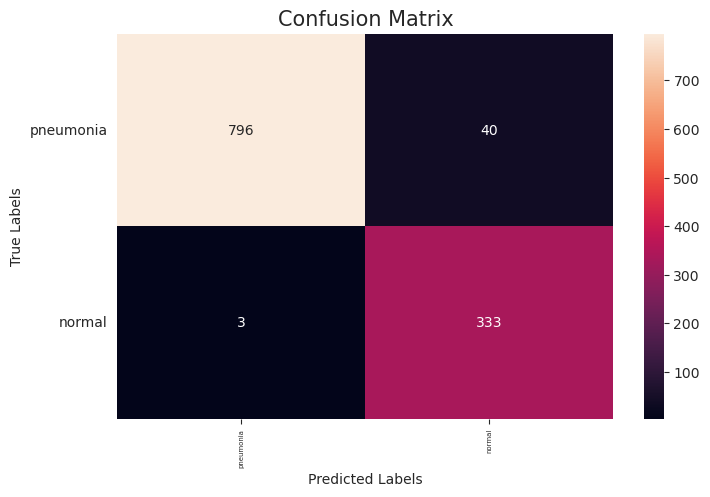

In [56]:
#Confusion matrix
Confusion_Matrix2 = confusion_matrix(y_test, y_pred)
print(Confusion_Matrix2)

import seaborn as sns

#Setting the labels
labels = ['pneumonia', 'normal']

#Plot the Confusion matrix graph
fig= plt.figure(figsize=(8, 5))
ax = plt.subplot()
sns.heatmap(Confusion_Matrix2, annot=True, ax = ax, fmt='g')
ax.set_xlabel('Predicted Labels', fontsize=10)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(labels, fontsize = 5)
ax.xaxis.tick_bottom()

ax.set_ylabel('True Labels', fontsize=10)
ax.yaxis.set_ticklabels(labels, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Confusion Matrix', fontsize=15)

plt.savefig('densenet201_ex.png')
plt.show()

In [57]:
#Classification report
print(classification_report(y_test, y_pred, target_names = ['Pneumonia (0)','Normal (1)']))

               precision    recall  f1-score   support

Pneumonia (0)       1.00      0.95      0.97       836
   Normal (1)       0.89      0.99      0.94       336

     accuracy                           0.96      1172
    macro avg       0.94      0.97      0.96      1172
 weighted avg       0.97      0.96      0.96      1172



In [58]:
#Accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % (accuracy*100))

Accuracy: 96.331058


In [59]:
#Precision
precision = precision_score(y_test, y_pred)
print('Precision: %f' % (precision*100))

Precision: 89.276139


In [60]:
# Recall
recall = recall_score(y_test, y_pred, pos_label=1)
print('Recall: %f' % (recall*100))

Recall: 99.107143


In [61]:
#F1-score
F1_score = f1_score(y_test, y_pred)
print('F1_score: %f' % (F1_score*100))

F1_score: 93.935120


In [62]:
#Specificity 
specificity = recall_score(y_test, y_pred, pos_label=0)
print('Specificity: %f' % (specificity*100))

Specificity: 95.215311


In [63]:
#Save the model
densenet201_model.save("densenet201_model.h5")

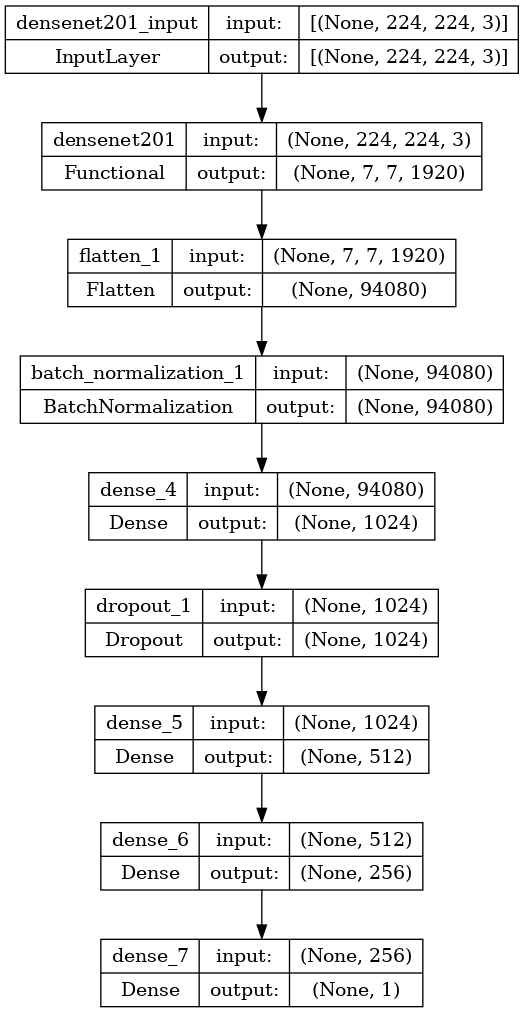

In [64]:
from tensorflow.keras.utils import plot_model

# Generate the plot
plot_model(densenet201_model, to_file='densenet201_model_architecture.png', show_shapes=True, show_layer_names=True)



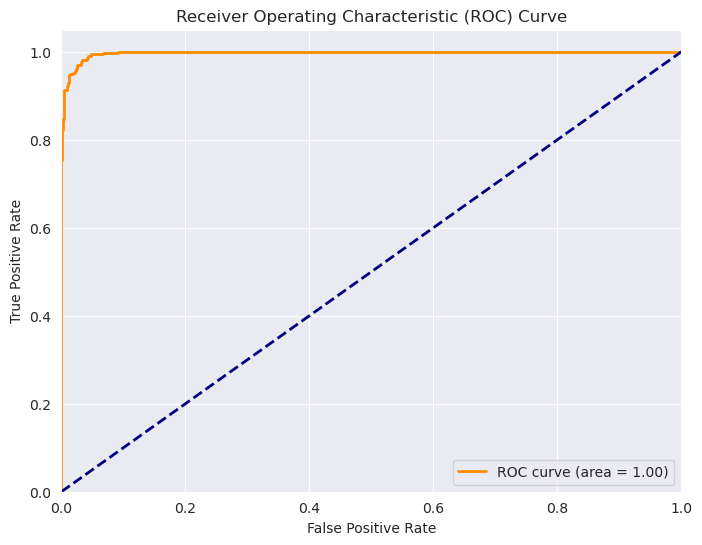

In [65]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, densenet201_predictions)

# Calculate AUC
roc_auc2 = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


1/1 [==============================] - 5s 5s/step


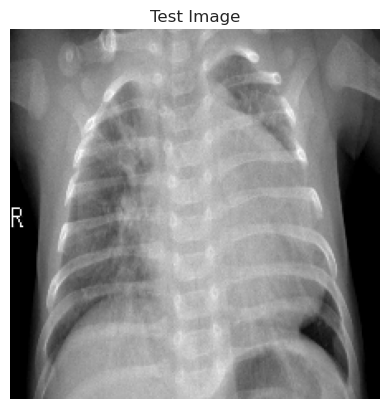

The predicted label is: Pneumonia


In [66]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

from tensorflow.keras.applications import DenseNet201

# Load the saved model
from tensorflow import keras
model = keras.models.load_model('/kaggle/working/densenet201_model.h5')


import numpy as np

image_path = r'/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person111_bacteria_537.jpeg'
image = load_img(image_path, target_size=(224, 224))
img = np.array(image) / 255.0
img = img.reshape(1, 224, 224, 3)

prediction = model.predict(img)
predicted_class = int(round(prediction[0][0]))  # 1 is for "Normal" and 0 is for "Pneumonia"

label_dict = {0: "Pneumonia", 1: "Normal"}
predicted_label = label_dict[predicted_class]
import matplotlib.pyplot as plt

# Plot the image
plt.imshow(image)
plt.axis('off')
plt.title('Test Image')
plt.show()
print(f"The predicted label is: {predicted_label}")


1/1 [==============================] - 3s 3s/step


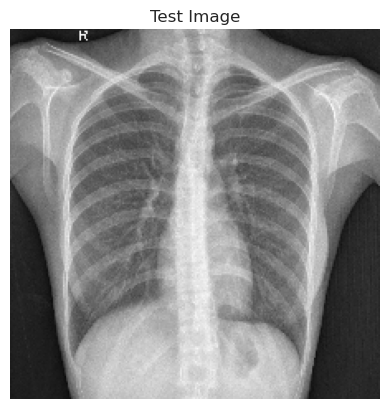

The predicted label is: Normal


In [67]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

from tensorflow.keras.applications import DenseNet201

# Load the saved model
from tensorflow import keras
model = keras.models.load_model('/kaggle/working/densenet201_model.h5')

import numpy as np

image_path = r'/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0035-0001.jpeg'
image = load_img(image_path, target_size=(224, 224))
img = np.array(image) / 255.0
img = img.reshape(1, 224, 224, 3)

prediction = model.predict(img)
predicted_class = int(round(prediction[0][0]))  #  1 is for "Normal" and 0 is for "Pneumonia"

label_dict = {0: "Pneumonia", 1: "Normal"}
predicted_label = label_dict[predicted_class]
# Plot the image
plt.imshow(image)
plt.axis('off')
plt.title('Test Image')
plt.show()
print(f"The predicted label is: {predicted_label}")

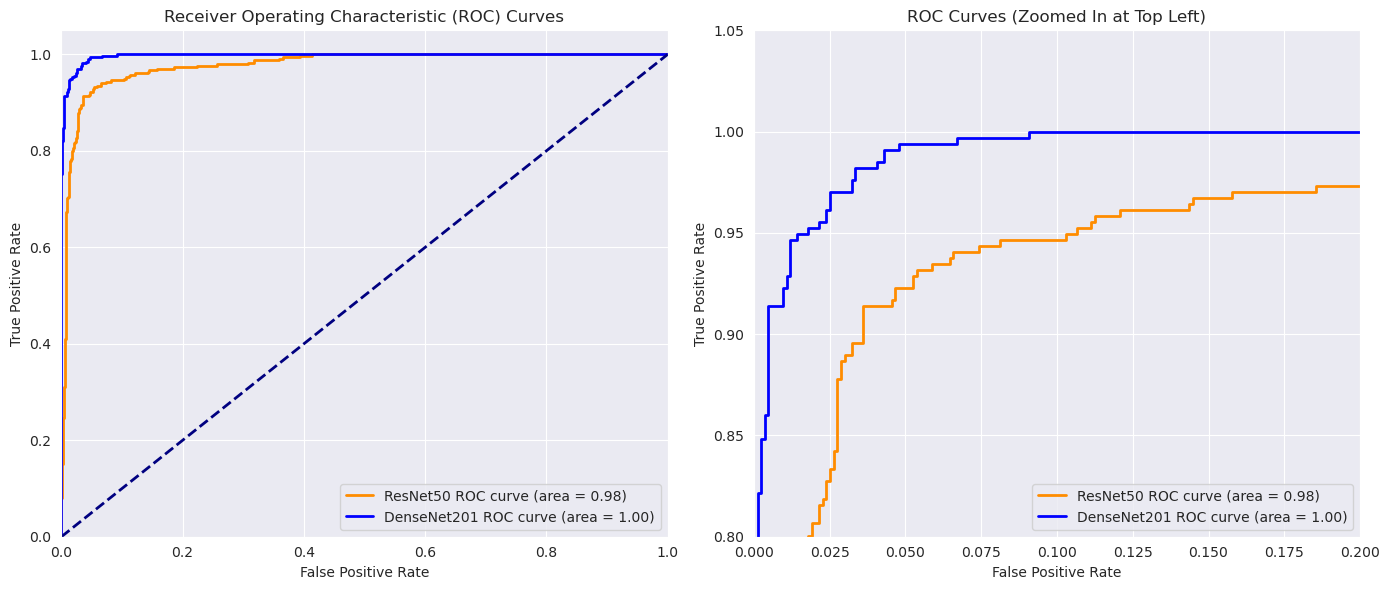

In [68]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for ResNet50 model
fpr_resnet50, tpr_resnet50, _ = roc_curve(y_test, resnet50_predictions)
roc_auc_resnet50 = auc(fpr_resnet50, tpr_resnet50)

# Compute ROC curve and ROC area for DenseNet201 model
fpr_densenet201, tpr_densenet201, _ = roc_curve(y_test, densenet201_predictions)
roc_auc_densenet201 = auc(fpr_densenet201, tpr_densenet201)

# Plot ROC curves for both models
plt.figure(figsize=(14, 6))

# Plot the full ROC curves
plt.subplot(1, 2, 1)
plt.plot(fpr_resnet50, tpr_resnet50, color='darkorange', lw=2, label='ResNet50 ROC curve (area = %0.2f)' % roc_auc_resnet50)
plt.plot(fpr_densenet201, tpr_densenet201, color='blue', lw=2, label='DenseNet201 ROC curve (area = %0.2f)' % roc_auc_densenet201)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')

# Plot the zoomed-in ROC curves
plt.subplot(1, 2, 2)
plt.plot(fpr_resnet50, tpr_resnet50, color='darkorange', lw=2, label='ResNet50 ROC curve (area = %0.2f)' % roc_auc_resnet50)
plt.plot(fpr_densenet201, tpr_densenet201, color='blue', lw=2, label='DenseNet201 ROC curve (area = %0.2f)' % roc_auc_densenet201)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 0.2])
plt.ylim([0.8, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Zoomed In at Top Left)')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


# VGG 19 Model

In [69]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19

# Loading the VGG19 model
vgg19_base_model = VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
)

# Making sure the layers of the VGG19 model are not retrained
for layer in vgg19_base_model.layers:
    layer.trainable = False

# Building the model
vgg19_model = tf.keras.models.Sequential()
vgg19_model.add(vgg19_base_model)
vgg19_model.add(tf.keras.layers.Flatten())
vgg19_model.add(tf.keras.layers.BatchNormalization())
vgg19_model.add(tf.keras.layers.Dense(1024, activation='relu'))
vgg19_model.add(tf.keras.layers.Dropout(0.5))
# Adding two more layers as requested
vgg19_model.add(tf.keras.layers.Dense(512, activation='relu'))
vgg19_model.add(tf.keras.layers.Dense(256, activation='relu'))
vgg19_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

vgg19_model.summary()

vgg19_model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

80134624/80134624 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 batch_normalization_2 (Batc  (None, 25088)            100352    
 hNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 1024)              25691136  
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_9 (Dense)             (None, 512)               

In [70]:
# Train the VGG19 model with early stopping
vgg19_model_history = vgg19_model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=50,
    validation_data=datagen.flow(x_val, y_val),
    callbacks=[early_stopping, learning_rate_reduction]
)

Epoch 1/50
118/118 [==============================] - 57s 429ms/step - loss: 0.5424 - accuracy: 0.8674 - val_loss: 0.3314 - val_accuracy: 0.9018 - lr: 0.0010
Epoch 2/50
118/118 [==============================] - 47s 401ms/step - loss: 0.2423 - accuracy: 0.9074 - val_loss: 0.2819 - val_accuracy: 0.8837 - lr: 0.0010
Epoch 3/50
118/118 [==============================] - 49s 414ms/step - loss: 0.1990 - accuracy: 0.9234 - val_loss: 0.1666 - val_accuracy: 0.9328 - lr: 0.0010
Epoch 4/50
118/118 [==============================] - 48s 408ms/step - loss: 0.1801 - accuracy: 0.9349 - val_loss: 0.1416 - val_accuracy: 0.9477 - lr: 0.0010
Epoch 5/50
118/118 [==============================] - 48s 408ms/step - loss: 0.1667 - accuracy: 0.9370 - val_loss: 0.1436 - val_accuracy: 0.9466 - lr: 0.0010
Epoch 6/50
118/118 [==============================] - 49s 418ms/step - loss: 0.1593 - accuracy: 0.9413 - val_loss: 0.1459 - val_accuracy: 0.9445 - lr: 0.0010
Epoch 7/50
118/118 [==============================] 

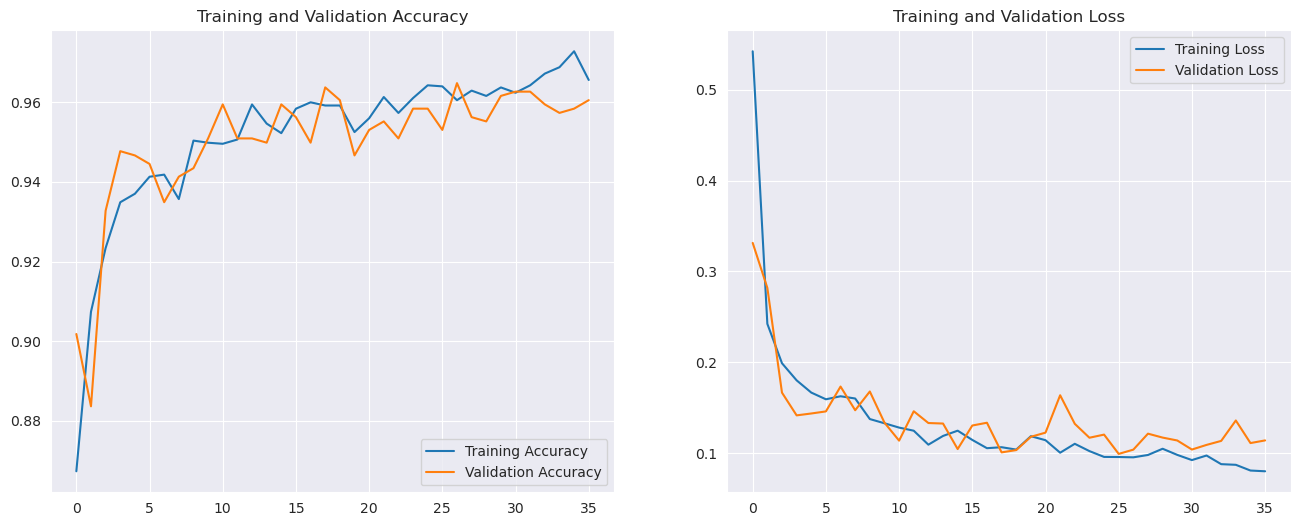

In [71]:
#Plotting the VGG19 model results

#Getting the accuracy
acc = vgg19_model_history.history['accuracy']
val_acc = vgg19_model_history.history['val_accuracy']

#Getting the losses
loss = vgg19_model_history.history['loss']
val_loss = vgg19_model_history.history['val_loss']

#No of epochs it trained
epochs_range = vgg19_model_history.epoch

#Plotting Training and Validation accuracy
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


# VGG19 Performance Evaluation

In [72]:
evaluation_result=vgg19_model.evaluate(x_test,y_test)

37/37 [==============================] - 8s 229ms/step - loss: 0.1592 - accuracy: 0.9403


In [73]:
print("Loss of the model is - " , evaluation_result[0])
print("Accuracy of the model is - " , evaluation_result[1]*100 , "%")

Loss of the model is -  0.15923146903514862
Accuracy of the model is -  94.02730464935303 %


In [74]:
vgg19_predictions = vgg19_model.predict(x_test)

37/37 [==============================] - 6s 150ms/step


In [75]:
y_pred = (vgg19_predictions> 0.5).astype("int32").flatten()

In [76]:
y_pred

array([0, 1, 1, ..., 0, 1, 0], dtype=int32)

In [77]:
y_test

array([0, 1, 1, ..., 0, 0, 0])

[[777  59]
 [ 11 325]]


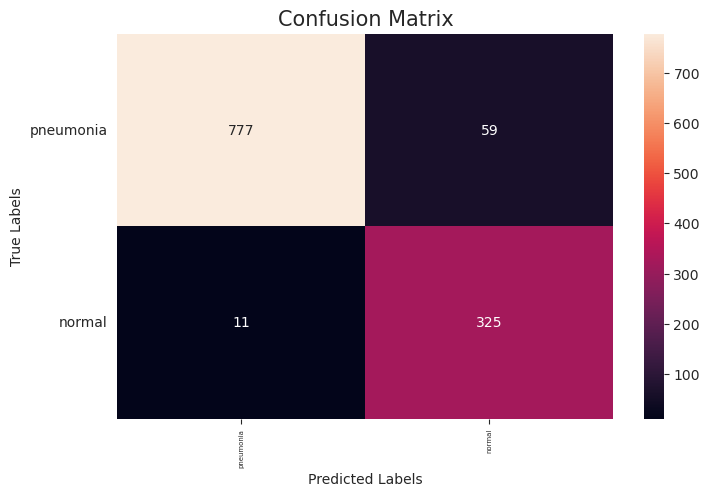

In [78]:
#Confusion matrix
Confusion_Matrix3 = confusion_matrix(y_test, y_pred)
print(Confusion_Matrix3)

import seaborn as sns

#Setting the labels
labels = ['pneumonia', 'normal']

#Plot the Confusion matrix graph
fig= plt.figure(figsize=(8, 5))
ax = plt.subplot()
sns.heatmap(Confusion_Matrix3, annot=True, ax = ax, fmt='g')
ax.set_xlabel('Predicted Labels', fontsize=10)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(labels, fontsize = 5)
ax.xaxis.tick_bottom()

ax.set_ylabel('True Labels', fontsize=10)
ax.yaxis.set_ticklabels(labels, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Confusion Matrix', fontsize=15)

plt.savefig('VGG19_ConMat24.png')
plt.show()

In [79]:
#Classification report
print(classification_report(y_test, y_pred, target_names = ['Pneumonia (0)','Normal (1)']))

               precision    recall  f1-score   support

Pneumonia (0)       0.99      0.93      0.96       836
   Normal (1)       0.85      0.97      0.90       336

     accuracy                           0.94      1172
    macro avg       0.92      0.95      0.93      1172
 weighted avg       0.95      0.94      0.94      1172



In [80]:
#Accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % (accuracy*100))

Accuracy: 94.027304


In [81]:
#Precision
precision = precision_score(y_test, y_pred)
print('Precision: %f' % (precision*100))

Precision: 84.635417


In [82]:
# Recall
recall = recall_score(y_test, y_pred, pos_label=1)
print('Recall: %f' % (recall*100))

Recall: 96.726190


In [83]:
#F1-score
F1_score = f1_score(y_test, y_pred)
print('F1_score: %f' % (F1_score*100))

F1_score: 90.277778


In [84]:
#Specificity 
specificity = recall_score(y_test, y_pred, pos_label=0)
print('Specificity: %f' % (specificity*100))

Specificity: 92.942584


In [85]:
#Save the model
vgg19_model.save("VGG19_model.h5")

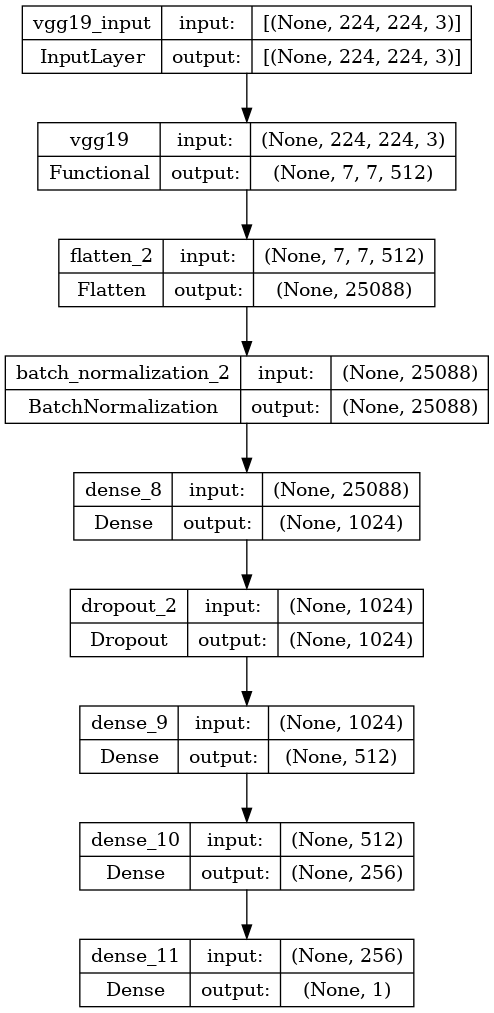

In [86]:
from tensorflow.keras.utils import plot_model

# Generate the plot
plot_model(vgg19_model, to_file='vgg19_model_architecture.png', show_shapes=True, show_layer_names=True)



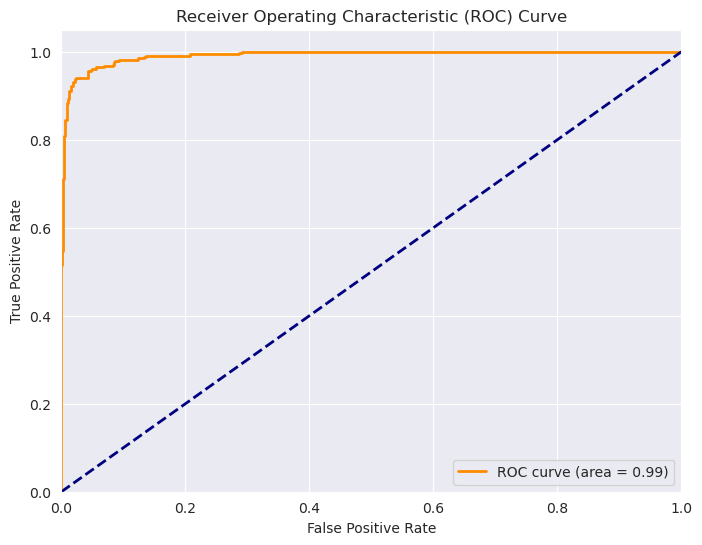

In [119]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, vgg19_predictions)

# Calculate AUC
roc_auc3 = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc3)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


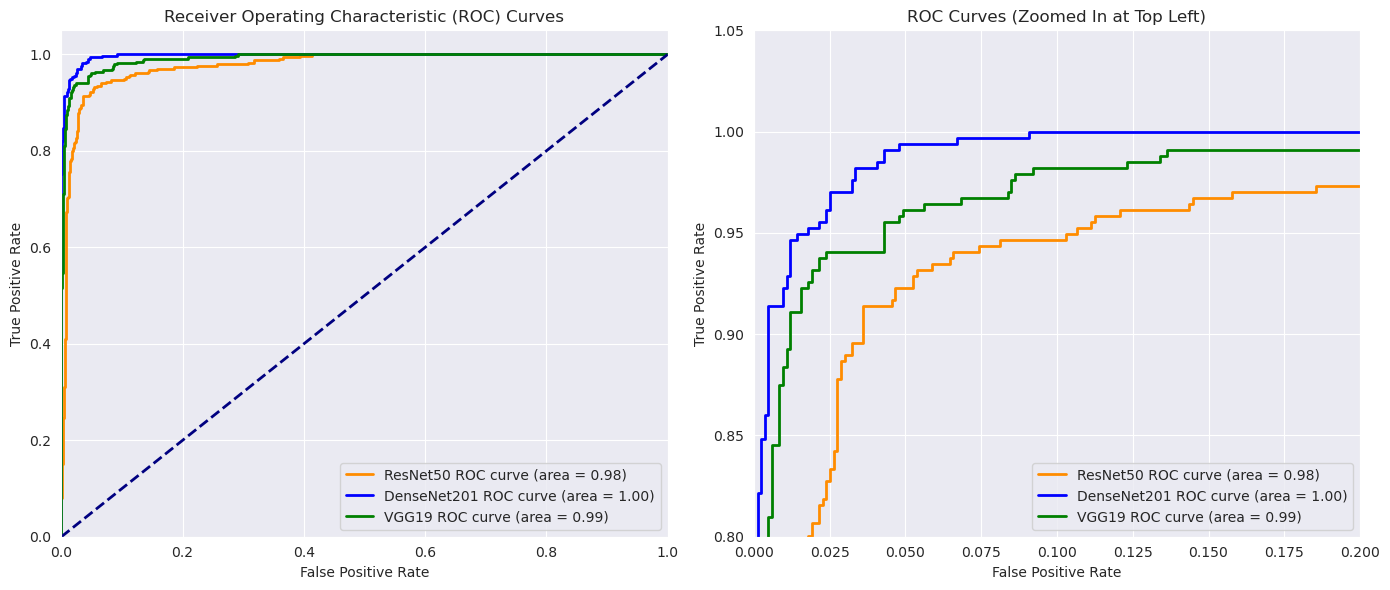

In [120]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for ResNet50 model
fpr_resnet50, tpr_resnet50, _ = roc_curve(y_test, resnet50_predictions)
roc_auc_resnet50 = auc(fpr_resnet50, tpr_resnet50)

# Compute ROC curve and ROC area for DenseNet201 model
fpr_densenet201, tpr_densenet201, _ = roc_curve(y_test, densenet201_predictions)
roc_auc_densenet201 = auc(fpr_densenet201, tpr_densenet201)

# Compute ROC curve and ROC area for VGG19 model
fpr_vgg19, tpr_vgg19, _ = roc_curve(y_test, vgg19_predictions)
roc_auc_vgg19 = auc(fpr_vgg19, tpr_vgg19)

# Plot ROC curves for all models
plt.figure(figsize=(14, 6))

# Plot the full ROC curves
plt.subplot(1, 2, 1)
plt.plot(fpr_resnet50, tpr_resnet50, color='darkorange', lw=2, label='ResNet50 ROC curve (area = %0.2f)' % roc_auc_resnet50)
plt.plot(fpr_densenet201, tpr_densenet201, color='blue', lw=2, label='DenseNet201 ROC curve (area = %0.2f)' % roc_auc_densenet201)
plt.plot(fpr_vgg19, tpr_vgg19, color='green', lw=2, label='VGG19 ROC curve (area = %0.2f)' % roc_auc_vgg19)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')

# Plot the zoomed-in ROC curves
plt.subplot(1, 2, 2)
plt.plot(fpr_resnet50, tpr_resnet50, color='darkorange', lw=2, label='ResNet50 ROC curve (area = %0.2f)' % roc_auc_resnet50)
plt.plot(fpr_densenet201, tpr_densenet201, color='blue', lw=2, label='DenseNet201 ROC curve (area = %0.2f)' % roc_auc_densenet201)
plt.plot(fpr_vgg19, tpr_vgg19, color='green', lw=2, label='VGG19 ROC curve (area = %0.2f)' % roc_auc_vgg19)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 0.2])
plt.ylim([0.8, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Zoomed In at Top Left)')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


1/1 [==============================] - 1s 759ms/step


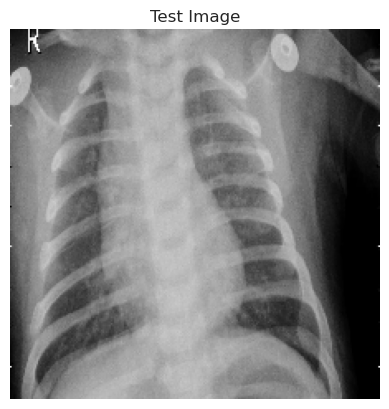

The predicted label is: Pneumonia


In [89]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

from tensorflow.keras.applications import VGG19

# Load the saved model
from tensorflow import keras
model = keras.models.load_model('/kaggle/working/VGG19_model.h5')


import numpy as np

image_path = r'/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person75_virus_136.jpeg'
image = load_img(image_path, target_size=(224, 224))
img = np.array(image) / 255.0
img = img.reshape(1, 224, 224, 3)

prediction = model.predict(img)
predicted_class = int(round(prediction[0][0]))  # 1 is for "Normal" and 0 is for "Pneumonia"

label_dict = {0: "Pneumonia", 1: "Normal"}
predicted_label = label_dict[predicted_class]
import matplotlib.pyplot as plt

# Plot the image
plt.imshow(image)
plt.axis('off')
plt.title('Test Image')
plt.show()
print(f"The predicted label is: {predicted_label}")


1/1 [==============================] - 0s 208ms/step


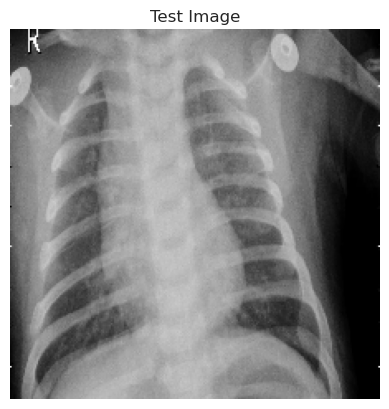

The predicted label is: Pneumonia


In [90]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

from tensorflow.keras.applications import VGG19

# Load the saved model
from tensorflow import keras
model = keras.models.load_model('/kaggle/working/VGG19_model.h5')


import numpy as np

image_path = r'/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person75_virus_136.jpeg'
image = load_img(image_path, target_size=(224, 224))
img = np.array(image) / 255.0
img = img.reshape(1, 224, 224, 3)

prediction = model.predict(img)
predicted_class = int(round(prediction[0][0]))  # 1 is for "Normal" and 0 is for "Pneumonia"

label_dict = {0: "Pneumonia", 1: "Normal"}
predicted_label = label_dict[predicted_class]
import matplotlib.pyplot as plt

# Plot the image
plt.imshow(image)
plt.axis('off')
plt.title('Test Image')
plt.show()
print(f"The predicted label is: {predicted_label}")


# InceptionV3


In [91]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3

# Loading the InceptionV3 model
inceptionv3_base_model = InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
)

# Making sure the layers of the InceptionV3 model are not retrained
for layer in inceptionv3_base_model.layers:
    layer.trainable = False

# Building the model
inceptionv3_model = tf.keras.models.Sequential()
inceptionv3_model.add(inceptionv3_base_model)
inceptionv3_model.add(tf.keras.layers.GlobalAveragePooling2D())
inceptionv3_model.add(tf.keras.layers.BatchNormalization())
inceptionv3_model.add(tf.keras.layers.Dense(1024, activation='relu'))
inceptionv3_model.add(tf.keras.layers.Dropout(0.5))
# Adding two more layers 
inceptionv3_model.add(tf.keras.layers.Dense(512, activation='relu'))
inceptionv3_model.add(tf.keras.layers.Dense(256, activation='relu'))
inceptionv3_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

inceptionv3_model.summary()

inceptionv3_model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)



87910968/87910968 [==============================] - 1s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization_97 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense_12 (Dense)            (None, 1024)              2098176   
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                       

In [92]:
# Train the InceptionV3 model with early stopping
inceptionv3_model_history = inceptionv3_model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=50,
    validation_data=datagen.flow(x_val, y_val),
    callbacks=[early_stopping, learning_rate_reduction]
)


Epoch 1/50
118/118 [==============================] - 57s 421ms/step - loss: 0.3359 - accuracy: 0.8644 - val_loss: 0.2743 - val_accuracy: 0.8805 - lr: 0.0010
Epoch 2/50
118/118 [==============================] - 47s 397ms/step - loss: 0.2708 - accuracy: 0.8978 - val_loss: 0.2467 - val_accuracy: 0.8954 - lr: 0.0010
Epoch 3/50
118/118 [==============================] - 47s 395ms/step - loss: 0.2244 - accuracy: 0.9079 - val_loss: 0.2085 - val_accuracy: 0.9178 - lr: 0.0010
Epoch 4/50
118/118 [==============================] - 46s 393ms/step - loss: 0.2052 - accuracy: 0.9175 - val_loss: 0.2192 - val_accuracy: 0.9093 - lr: 0.0010
Epoch 5/50
118/118 [==============================] - 46s 393ms/step - loss: 0.1963 - accuracy: 0.9213 - val_loss: 0.2356 - val_accuracy: 0.9082 - lr: 0.0010
Epoch 6/50
118/118 [==============================] - 47s 396ms/step - loss: 0.2140 - accuracy: 0.9165 - val_loss: 0.1950 - val_accuracy: 0.9178 - lr: 0.0010
Epoch 7/50
118/118 [==============================] 

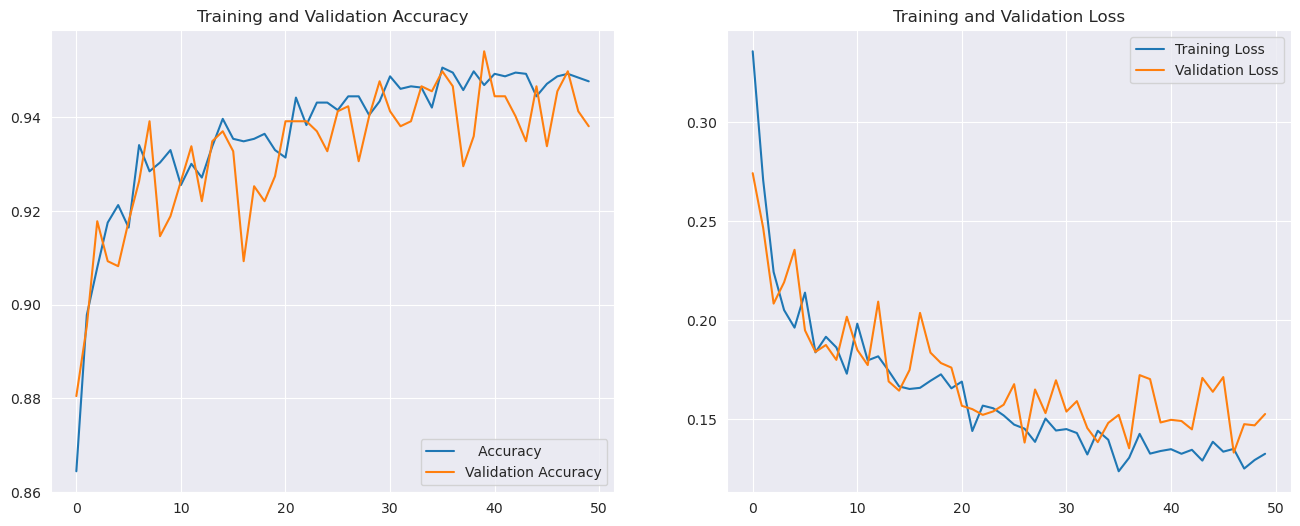

In [93]:
#Plotting the inceptionv3 model results

#Getting the accuracy
acc = inceptionv3_model_history.history['accuracy']
val_acc = inceptionv3_model_history.history['val_accuracy']

#Getting the losses
loss = inceptionv3_model_history.history['loss']
val_loss = inceptionv3_model_history.history['val_loss']

#No of epochs it trained
epochs_range = inceptionv3_model_history.epoch

#Plotting Training and Validation accuracy
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='   Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [94]:
evaluation_result=inceptionv3_model.evaluate(x_test,np.array(y_test))

37/37 [==============================] - 4s 100ms/step - loss: 0.1509 - accuracy: 0.9480


In [95]:
print("Loss of the model is - " , evaluation_result[0])
print("Accuracy of the model is - " , evaluation_result[1]*100 , "%")

Loss of the model is -  0.1508864462375641
Accuracy of the model is -  94.79522109031677 %


In [96]:
inceptionv3_predictions = inceptionv3_model.predict(x_test)

37/37 [==============================] - 4s 63ms/step


In [97]:
y_pred = (inceptionv3_predictions> 0.5).astype("int32").flatten()

In [98]:
y_pred

array([0, 0, 1, ..., 0, 0, 0], dtype=int32)

In [99]:
y_test

array([0, 1, 1, ..., 0, 0, 0])

[[792  44]
 [ 17 319]]


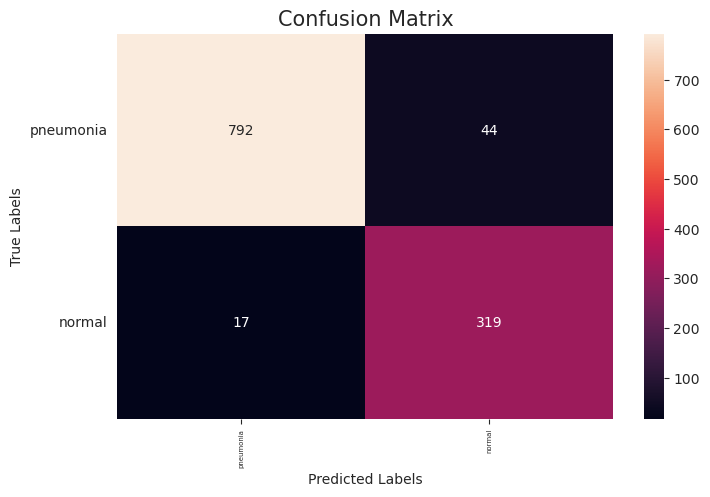

In [101]:
#Confusion matrix
Confusion_Matrix4 = confusion_matrix(y_test, y_pred)
print(Confusion_Matrix4)

import seaborn as sns

#Setting the labels
labels = ['pneumonia', 'normal']

#Plot the Confusion matrix graph
fig= plt.figure(figsize=(8, 5))
ax = plt.subplot()
sns.heatmap(Confusion_Matrix4, annot=True, ax = ax, fmt='g')
ax.set_xlabel('Predicted Labels', fontsize=10)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(labels, fontsize = 5)
ax.xaxis.tick_bottom()

ax.set_ylabel('True Labels', fontsize=10)
ax.yaxis.set_ticklabels(labels, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Confusion Matrix', fontsize=15)

plt.savefig('inceptionv3_ConMat24.png')
plt.show()

In [102]:
#Classification report
print(classification_report(y_test, y_pred, target_names = ['Pneumonia (0)','Normal (1)']))

               precision    recall  f1-score   support

Pneumonia (0)       0.98      0.95      0.96       836
   Normal (1)       0.88      0.95      0.91       336

     accuracy                           0.95      1172
    macro avg       0.93      0.95      0.94      1172
 weighted avg       0.95      0.95      0.95      1172



In [103]:
#Accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % (accuracy*100))

Accuracy: 94.795222


In [104]:
#Precision
precision = precision_score(y_test, y_pred)
print('Precision: %f' % (precision*100))

Precision: 87.878788


In [105]:
#Classification report
print(classification_report(y_test, y_pred, target_names = ['Pneumonia (0)','Normal (1)']))

               precision    recall  f1-score   support

Pneumonia (0)       0.98      0.95      0.96       836
   Normal (1)       0.88      0.95      0.91       336

     accuracy                           0.95      1172
    macro avg       0.93      0.95      0.94      1172
 weighted avg       0.95      0.95      0.95      1172



In [106]:
#Accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % (accuracy*100))

Accuracy: 94.795222


In [107]:
#Precision
precision = precision_score(y_test, y_pred)
print('Precision: %f' % (precision*100))

Precision: 87.878788


In [108]:
# Recall
recall = recall_score(y_test, y_pred, pos_label=1)
print('Recall: %f' % (recall*100))

Recall: 94.940476


In [109]:
#F1-score
F1_score = f1_score(y_test, y_pred)
print('F1_score: %f' % (F1_score*100))

F1_score: 91.273247


In [110]:
#Specificity 
specificity = recall_score(y_test, y_pred, pos_label=0)
print('Specificity: %f' % (specificity*100))

Specificity: 94.736842


In [111]:
#Save the model
inceptionv3_model.save("inceptionv3_model.h5")

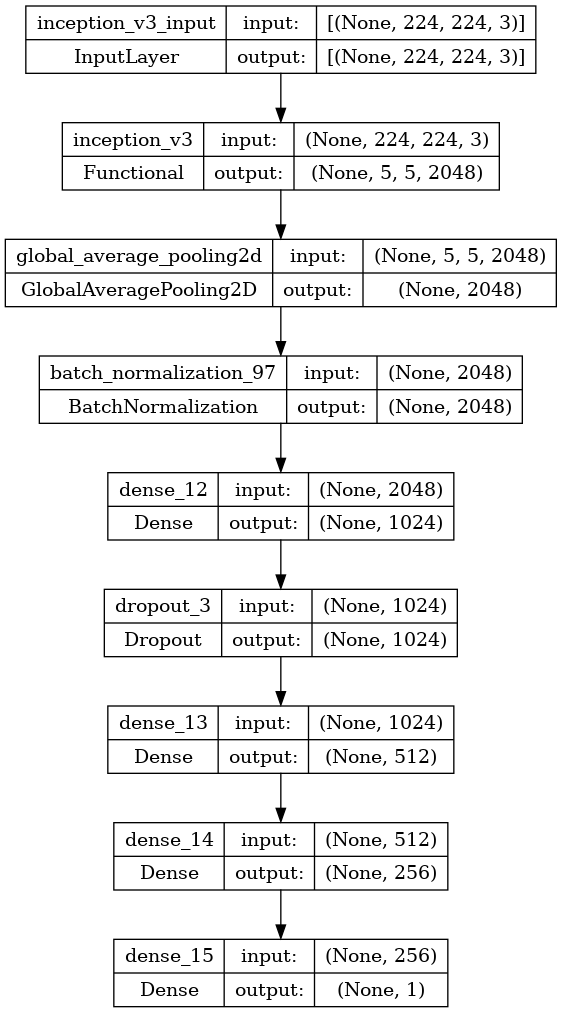

In [112]:
from tensorflow.keras.utils import plot_model

# Generate the plot
plot_model(inceptionv3_model, to_file='inceptionv3_model_architecture.png', show_shapes=True, show_layer_names=True)



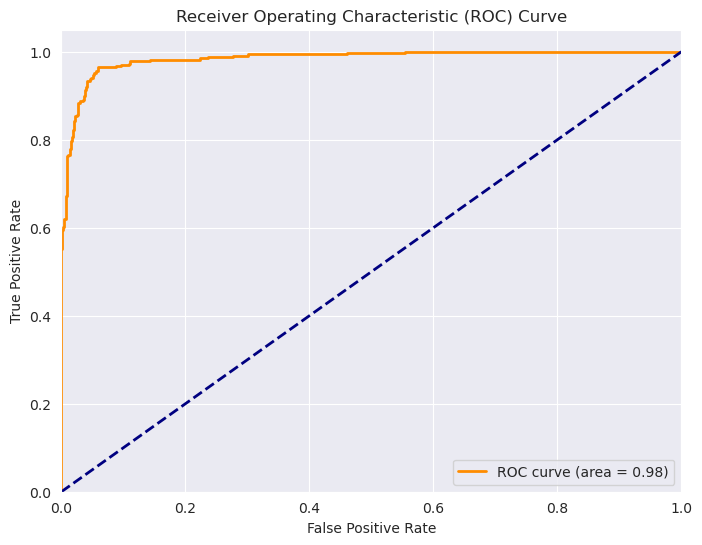

In [118]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, inceptionv3_predictions)

# Calculate AUC
roc_auc4 = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc4)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


1/1 [==============================] - 2s 2s/step


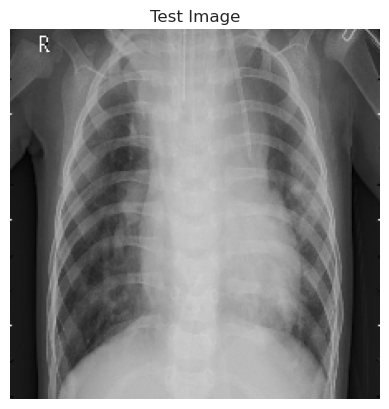

The predicted label is: Pneumonia


In [115]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

from tensorflow.keras.applications import InceptionV3

# Load the saved model
from tensorflow import keras
model = keras.models.load_model('/kaggle/working/inceptionv3_model.h5')


import numpy as np

image_path = r'/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person103_bacteria_488.jpeg'
image = load_img(image_path, target_size=(224, 224))
img = np.array(image) / 255.0
img = img.reshape(1, 224, 224, 3)

prediction = model.predict(img)
predicted_class = int(round(prediction[0][0]))  # 1 is for "Normal" and 0 is for "Pneumonia"

label_dict = {0: "Pneumonia", 1: "Normal"}
predicted_label = label_dict[predicted_class]
import matplotlib.pyplot as plt

# Plot the image
plt.imshow(image)
plt.axis('off')
plt.title('Test Image')
plt.show()
print(f"The predicted label is: {predicted_label}")


1/1 [==============================] - 1s 1s/step


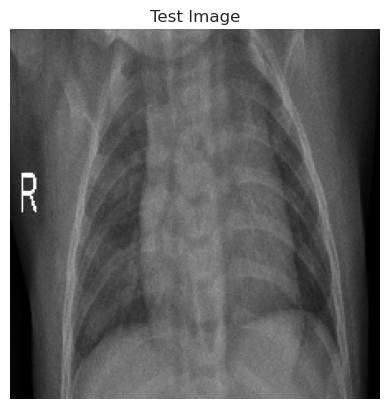

The predicted label is: Pneumonia


In [116]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

from tensorflow.keras.applications import InceptionV3

# Load the saved model
from tensorflow import keras
model = keras.models.load_model('/kaggle/working/inceptionv3_model.h5')

import numpy as np

image_path = r'/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0022-0001.jpeg'
image = load_img(image_path, target_size=(224, 224))
img = np.array(image) / 255.0
img = img.reshape(1, 224, 224, 3)

prediction = model.predict(img)
predicted_class = int(round(prediction[0][0]))  #  1 is for "Normal" and 0 is for "Pneumonia"

label_dict = {0: "Pneumonia", 1: "Normal"}
predicted_label = label_dict[predicted_class]
# Plot the image
plt.imshow(image)
plt.axis('off')
plt.title('Test Image')
plt.show()
print(f"The predicted label is: {predicted_label}")

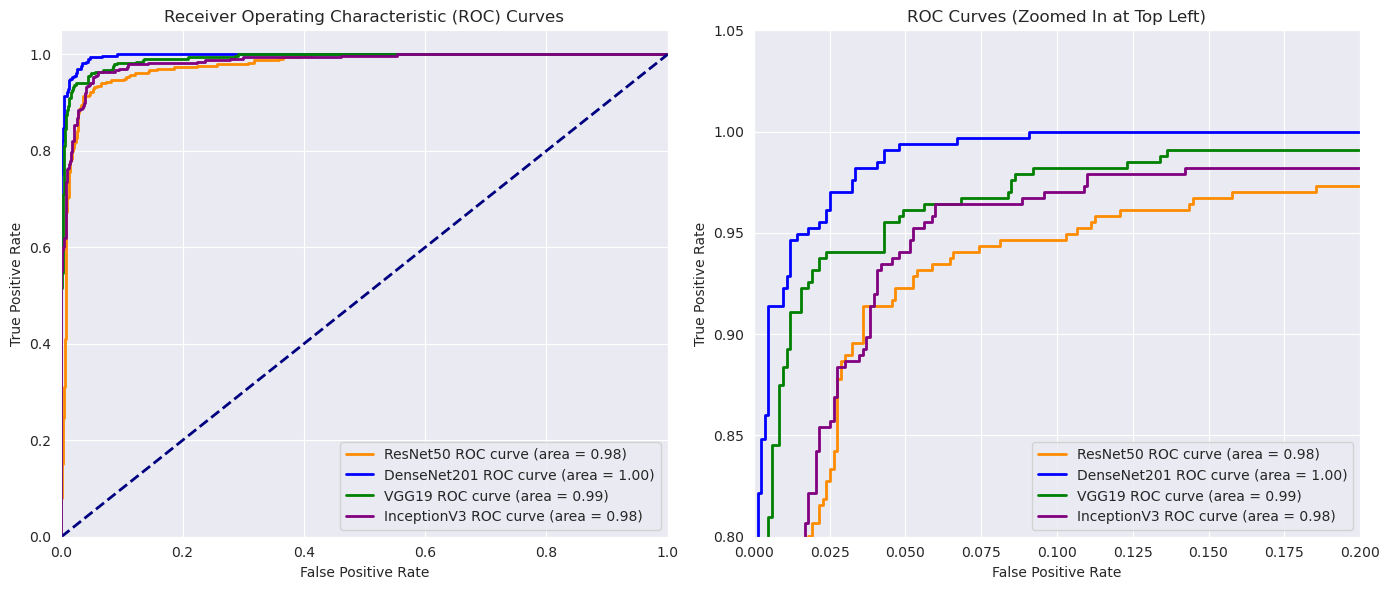

In [117]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for ResNet50 model
fpr_resnet50, tpr_resnet50, _ = roc_curve(y_test, resnet50_predictions)
roc_auc_resnet50 = auc(fpr_resnet50, tpr_resnet50)

# Compute ROC curve and ROC area for DenseNet201 model
fpr_densenet201, tpr_densenet201, _ = roc_curve(y_test, densenet201_predictions)
roc_auc_densenet201 = auc(fpr_densenet201, tpr_densenet201)

# Compute ROC curve and ROC area for VGG19 model
fpr_vgg19, tpr_vgg19, _ = roc_curve(y_test, vgg19_predictions)
roc_auc_vgg19 = auc(fpr_vgg19, tpr_vgg19)

# Compute ROC curve and ROC area for InceptionV3 model
fpr_inceptionv3, tpr_inceptionv3, _ = roc_curve(y_test, inceptionv3_predictions)
roc_auc_inceptionv3 = auc(fpr_inceptionv3, tpr_inceptionv3)

# Plot ROC curves for all models
plt.figure(figsize=(14, 6))

# Plot the full ROC curves
plt.subplot(1, 2, 1)
plt.plot(fpr_resnet50, tpr_resnet50, color='darkorange', lw=2, label='ResNet50 ROC curve (area = %0.2f)' % roc_auc_resnet50)
plt.plot(fpr_densenet201, tpr_densenet201, color='blue', lw=2, label='DenseNet201 ROC curve (area = %0.2f)' % roc_auc_densenet201)
plt.plot(fpr_vgg19, tpr_vgg19, color='green', lw=2, label='VGG19 ROC curve (area = %0.2f)' % roc_auc_vgg19)
plt.plot(fpr_inceptionv3, tpr_inceptionv3, color='purple', lw=2, label='InceptionV3 ROC curve (area = %0.2f)' % roc_auc_inceptionv3)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')

# Plot the zoomed-in ROC curves
plt.subplot(1, 2, 2)
plt.plot(fpr_resnet50, tpr_resnet50, color='darkorange', lw=2, label='ResNet50 ROC curve (area = %0.2f)' % roc_auc_resnet50)
plt.plot(fpr_densenet201, tpr_densenet201, color='blue', lw=2, label='DenseNet201 ROC curve (area = %0.2f)' % roc_auc_densenet201)
plt.plot(fpr_vgg19, tpr_vgg19, color='green', lw=2, label='VGG19 ROC curve (area = %0.2f)' % roc_auc_vgg19)
plt.plot(fpr_inceptionv3, tpr_inceptionv3, color='purple', lw=2, label='InceptionV3 ROC curve (area = %0.2f)' % roc_auc_inceptionv3)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 0.2])
plt.ylim([0.8, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Zoomed In at Top Left)')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


# EfficientNetB3

In [121]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3

# Loading the EfficientNetB3 model
efficientnetb3_base_model = EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
)

# Making sure the layers of the EfficientNetB3 model are not retrained
for layer in efficientnetb3_base_model.layers:
    layer.trainable = False

# Building the model
efficientnetb3_model = tf.keras.models.Sequential()
efficientnetb3_model.add(efficientnetb3_base_model)
efficientnetb3_model.add(tf.keras.layers.GlobalAveragePooling2D())
efficientnetb3_model.add(tf.keras.layers.BatchNormalization())
efficientnetb3_model.add(tf.keras.layers.Dense(1024, activation='relu'))
efficientnetb3_model.add(tf.keras.layers.Dropout(0.5))
# Adding two more layers as requested
efficientnetb3_model.add(tf.keras.layers.Dense(512, activation='relu'))
efficientnetb3_model.add(tf.keras.layers.Dense(256, activation='relu'))
efficientnetb3_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

efficientnetb3_model.summary()

efficientnetb3_model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)



43941136/43941136 [==============================] - 0s 0us/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 7, 7, 1536)       10783535  
                                                                 
 global_average_pooling2d_1   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_98 (Bat  (None, 1536)             6144      
 chNormalization)                                                
                                                                 
 dense_16 (Dense)            (None, 1024)              1573888   
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                       

In [122]:
# Train the EfficientNetB3 model with early stopping
efficientnetb3_model_history = efficientnetb3_model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=50,
    validation_data=datagen.flow(x_val, y_val),
    callbacks=[early_stopping, learning_rate_reduction]
)


Epoch 1/50


2024-05-23 02:27:12.457976: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


118/118 [==============================] - 64s 441ms/step - loss: 0.6554 - accuracy: 0.6958 - val_loss: 0.6895 - val_accuracy: 0.6681 - lr: 0.0010
Epoch 2/50
118/118 [==============================] - 47s 400ms/step - loss: 0.5769 - accuracy: 0.7171 - val_loss: 0.6762 - val_accuracy: 0.7428 - lr: 0.0010
Epoch 3/50
118/118 [==============================] - 48s 402ms/step - loss: 0.5545 - accuracy: 0.7334 - val_loss: 0.6126 - val_accuracy: 0.7599 - lr: 0.0010
Epoch 4/50
118/118 [==============================] - 48s 403ms/step - loss: 0.5493 - accuracy: 0.7321 - val_loss: 0.5576 - val_accuracy: 0.7449 - lr: 0.0010
Epoch 5/50
118/118 [==============================] - 48s 404ms/step - loss: 0.5331 - accuracy: 0.7430 - val_loss: 0.4895 - val_accuracy: 0.7641 - lr: 0.0010
Epoch 7/50
118/118 [==============================] - 47s 400ms/step - loss: 0.5337 - accuracy: 0.7379 - val_loss: 0.4546 - val_accuracy: 0.7524 - lr: 0.0010
Epoch 8/50
118/118 [==============================] - 47s 397ms

In [ ]:
#Plotting the densenet201 model results

#Getting the accuracy
acc = efficientnetb3_model_history.history['accuracy']
val_acc = efficientnetb3_model_history.history['val_accuracy']

#Getting the losses
loss = efficientnetb3_model_history.history['loss']
val_loss = efficientnetb3_model_history.history['val_loss']

#No of epochs it trained
epochs_range = efficientnetb3_model_history.epoch

#Plotting Training and Validation accuracy
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='   Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
evaluation_result=efficientnetb3_model.evaluate(x_test,np.array(y_test))

In [ ]:
print("Loss of the model is - " , evaluation_result[0])
print("Accuracy of the model is - " , evaluation_result[1]*100 , "%")

In [ ]:
efficientnetb3_predictions = efficientnetb3_model.predict(x_test)

In [ ]:
y_pred = (efficientnetb3_predictions> 0.5).astype("int32").flatten()

In [ ]:
y_pred

In [ ]:
y_test

In [ ]:
#Confusion matrix
Confusion_Matrix4 = confusion_matrix(y_test, y_pred)
print(Confusion_Matrix4)

import seaborn as sns

#Setting the labels
labels = ['pneumonia', 'normal']

#Plot the Confusion matrix graph
fig= plt.figure(figsize=(8, 5))
ax = plt.subplot()
sns.heatmap(Confusion_Matrix2, annot=True, ax = ax, fmt='g')
ax.set_xlabel('Predicted Labels', fontsize=10)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(labels, fontsize = 5)
ax.xaxis.tick_bottom()

ax.set_ylabel('True Labels', fontsize=10)
ax.yaxis.set_ticklabels(labels, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Confusion Matrix', fontsize=15)

plt.savefig('efficientnetb3_ex.png')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred, target_names = ['Pneumonia (0)','Normal (1)']))

In [ ]:
#Accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % (accuracy*100))

In [ ]:
#Precision
precision = precision_score(y_test, y_pred)
print('Precision: %f' % (precision*100))

In [ ]:
# Recall
recall = recall_score(y_test, y_pred, pos_label=1)
print('Recall: %f' % (recall*100))

In [ ]:
#F1-score
F1_score = f1_score(y_test, y_pred)
print('F1_score: %f' % (F1_score*100))

In [ ]:
#Specificity 
specificity = recall_score(y_test, y_pred, pos_label=0)
print('Specificity: %f' % (specificity*100))

In [ ]:
#Save the model
efficientnetb3_model.save("efficientnetb3_model.h5")

In [ ]:
from tensorflow.keras.utils import plot_model

# Generate the plot
plot_model(efficientnetb3_model, to_file='efficientnetb3_model_architecture.png', show_shapes=True, show_layer_names=True)


In [ ]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, efficientnetb3_predictions)

# Calculate AUC
roc_auc4 = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

from tensorflow.keras.applications import EfficientNetB3

# Load the saved model
from tensorflow import keras
model = keras.models.load_model('/kaggle/working/efficientnetb3_model.h5')


import numpy as np

image_path = r'/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person111_bacteria_537.jpeg'
image = load_img(image_path, target_size=(224, 224))
img = np.array(image) / 255.0
img = img.reshape(1, 224, 224, 3)

prediction = model.predict(img)
predicted_class = int(round(prediction[0][0]))  # 1 is for "Normal" and 0 is for "Pneumonia"

label_dict = {0: "Pneumonia", 1: "Normal"}
predicted_label = label_dict[predicted_class]
import matplotlib.pyplot as plt

# Plot the image
plt.imshow(image)
plt.axis('off')
plt.title('Test Image')
plt.show()
print(f"The predicted label is: {predicted_label}")


In [ ]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

from tensorflow.keras.applications import DenseNet201

# Load the saved model
from tensorflow import keras
model = keras.models.load_model('/kaggle/working/efficientnetb3_model.h5')

import numpy as np

image_path = r'/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0035-0001.jpeg'
image = load_img(image_path, target_size=(224, 224))
img = np.array(image) / 255.0
img = img.reshape(1, 224, 224, 3)

prediction = model.predict(img)
predicted_class = int(round(prediction[0][0]))  #  1 is for "Normal" and 0 is for "Pneumonia"

label_dict = {0: "Pneumonia", 1: "Normal"}
predicted_label = label_dict[predicted_class]
# Plot the image
plt.imshow(image)
plt.axis('off')
plt.title('Test Image')
plt.show()
print(f"The predicted label is: {predicted_label}")

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for ResNet50 model
fpr_resnet50, tpr_resnet50, _ = roc_curve(y_test, resnet50_predictions)
roc_auc_resnet50 = auc(fpr_resnet50, tpr_resnet50)

# Compute ROC curve and ROC area for DenseNet201 model
fpr_densenet201, tpr_densenet201, _ = roc_curve(y_test, densenet201_predictions)
roc_auc_densenet201 = auc(fpr_densenet201, tpr_densenet201)

# Compute ROC curve and ROC area for VGG19 model
fpr_vgg19, tpr_vgg19, _ = roc_curve(y_test, vgg19_predictions)
roc_auc_vgg19 = auc(fpr_vgg19, tpr_vgg19)

# Compute ROC curve and ROC area for InceptionV3 model
fpr_inceptionv3, tpr_inceptionv3, _ = roc_curve(y_test, inceptionv3_predictions)
roc_auc_inceptionv3 = auc(fpr_inceptionv3, tpr_inceptionv3)

# Compute ROC curve and ROC area for EfficientNetB3 model
fpr_efficientnetb3, tpr_efficientnetb3, _ = roc_curve(y_test, efficientnetb3_predictions)
roc_auc_efficientnetb3 = auc(fpr_efficientnetb3, tpr_efficientnetb3)

# Plot ROC curves for all models
plt.figure(figsize=(14, 6))

# Plot the full ROC curves
plt.subplot(1, 2, 1)
plt.plot(fpr_resnet50, tpr_resnet50, color='darkorange', lw=2, label='ResNet50 ROC curve (area = %0.2f)' % roc_auc_resnet50)
plt.plot(fpr_densenet201, tpr_densenet201, color='blue', lw=2, label='DenseNet201 ROC curve (area = %0.2f)' % roc_auc_densenet201)
plt.plot(fpr_vgg19, tpr_vgg19, color='green', lw=2, label='VGG19 ROC curve (area = %0.2f)' % roc_auc_vgg19)
plt.plot(fpr_inceptionv3, tpr_inceptionv3, color='purple', lw=2, label='InceptionV3 ROC curve (area = %0.2f)' % roc_auc_inceptionv3)
plt.plot(fpr_efficientnetb3, tpr_efficientnetb3, color='red', lw=2, label='EfficientNetB3 ROC curve (area = %0.2f)' % roc_auc_efficientnetb3)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')

# Plot the zoomed-in ROC curves
plt.subplot(1, 2, 2)
plt.plot(fpr_resnet50, tpr_resnet50, color='darkorange', lw=2, label='ResNet50 ROC curve (area = %0.2f)' % roc_auc_resnet50)
plt.plot(fpr_densenet201, tpr_densenet201, color='blue', lw=2, label='DenseNet201 ROC curve (area = %0.2f)' % roc_auc_densenet201)
plt.plot(fpr_vgg19, tpr_vgg19, color='green', lw=2, label='VGG19 ROC curve (area = %0.2f)' % roc_auc_vgg19)
plt.plot(fpr_inceptionv3, tpr_inceptionv3, color='purple', lw=2, label='InceptionV3 ROC curve (area = %0.2f)' % roc_auc_inceptionv3)
plt.plot(fpr_efficientnetb3, tpr_efficientnetb3, color='red', lw=2, label='EfficientNetB3 ROC curve (area = %0.2f)' % roc_auc_efficientnetb3)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 0.2])
plt.ylim([0.8, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Zoomed In at Top Left)')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


# Xception

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import Xception

# Loading the Xception model
xception_base_model = Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
)

# Making sure the layers of the Xception model are not retrained
for layer in xception_base_model.layers:
    layer.trainable = False

# Building the model
xception_model = tf.keras.models.Sequential()
xception_model.add(xception_base_model)
xception_model.add(tf.keras.layers.GlobalAveragePooling2D())
xception_model.add(tf.keras.layers.BatchNormalization())
xception_model.add(tf.keras.layers.Dense(1024, activation='relu'))
xception_model.add(tf.keras.layers.Dropout(0.5))
# Adding two more layers as requested
xception_model.add(tf.keras.layers.Dense(512, activation='relu'))
xception_model.add(tf.keras.layers.Dense(256, activation='relu'))
xception_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

xception_model.summary()

xception_model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)



In [ ]:
# Train the Xception model with early stopping
xception_model_history = xception_model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=50,
    validation_data=datagen.flow(x_val, y_val),
    callbacks=[early_stopping, learning_rate_reduction]
)


In [ ]:
#Plotting the xception model results

#Getting the accuracy
acc = xception_model_history.history['accuracy']
val_acc = xception_model_history.history['val_accuracy']

#Getting the losses
loss = xception_model_history.history['loss']
val_loss = xception_model_history.history['val_loss']

#No of epochs it trained
epochs_range = xception_model_history.epoch

#Plotting Training and Validation accuracy
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='   Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
evaluation_result=xception_model.evaluate(x_test,np.array(y_test))

In [ ]:
print("Loss of the model is - " , evaluation_result[0])
print("Accuracy of the model is - " , evaluation_result[1]*100 , "%")

In [ ]:
xception_predictions = densenet201_model.predict(x_test)

In [ ]:
y_pred = (xception_predictions> 0.5).astype("int32").flatten()

In [ ]:
y_pred

In [ ]:
y_test

In [ ]:
#Confusion matrix
Confusion_Matrix5 = confusion_matrix(y_test, y_pred)
print(Confusion_Matrix5)

import seaborn as sns

#Setting the labels
labels = ['pneumonia', 'normal']

#Plot the Confusion matrix graph
fig= plt.figure(figsize=(8, 5))
ax = plt.subplot()
sns.heatmap(Confusion_Matrix2, annot=True, ax = ax, fmt='g')
ax.set_xlabel('Predicted Labels', fontsize=10)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(labels, fontsize = 5)
ax.xaxis.tick_bottom()

ax.set_ylabel('True Labels', fontsize=10)
ax.yaxis.set_ticklabels(labels, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Confusion Matrix', fontsize=15)

plt.savefig('xception_ex.png')
plt.show()

In [ ]:
#Classification report
print(classification_report(y_test, y_pred, target_names = ['Pneumonia (0)','Normal (1)']))

In [ ]:
#Accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % (accuracy*100))

In [ ]:
#Precision
precision = precision_score(y_test, y_pred)
print('Precision: %f' % (precision*100))

In [ ]:
# Recall
recall = recall_score(y_test, y_pred, pos_label=1)
print('Recall: %f' % (recall*100))

In [ ]:
#F1-score
F1_score = f1_score(y_test, y_pred)
print('F1_score: %f' % (F1_score*100))

In [ ]:
#Specificity 
specificity = recall_score(y_test, y_pred, pos_label=0)
print('Specificity: %f' % (specificity*100))

In [ ]:
#Save the model
xception_model.save("xception_model.h5")

In [ ]:
from tensorflow.keras.utils import plot_model

# Generate the plot
plot_model(xception_model, to_file='xception_model_architecture.png', show_shapes=True, show_layer_names=True)



In [ ]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, xception_predictions)

# Calculate AUC
roc_auc2 = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

from tensorflow.keras.applications import DenseNet201

# Load the saved model
from tensorflow import keras
model = keras.models.load_model('/kaggle/working/xception_model.h5')


import numpy as np

image_path = r'/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person111_bacteria_537.jpeg'
image = load_img(image_path, target_size=(224, 224))
img = np.array(image) / 255.0
img = img.reshape(1, 224, 224, 3)

prediction = model.predict(img)
predicted_class = int(round(prediction[0][0]))  # 1 is for "Normal" and 0 is for "Pneumonia"

label_dict = {0: "Pneumonia", 1: "Normal"}
predicted_label = label_dict[predicted_class]
import matplotlib.pyplot as plt

# Plot the image
plt.imshow(image)
plt.axis('off')
plt.title('Test Image')
plt.show()
print(f"The predicted label is: {predicted_label}")


In [ ]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

from tensorflow.keras.applications import DenseNet201

# Load the saved model
from tensorflow import keras
model = keras.models.load_model('/kaggle/working/xception_model.h5')

import numpy as np

image_path = r'/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0035-0001.jpeg'
image = load_img(image_path, target_size=(224, 224))
img = np.array(image) / 255.0
img = img.reshape(1, 224, 224, 3)

prediction = model.predict(img)
predicted_class = int(round(prediction[0][0]))  #  1 is for "Normal" and 0 is for "Pneumonia"

label_dict = {0: "Pneumonia", 1: "Normal"}
predicted_label = label_dict[predicted_class]
# Plot the image
plt.imshow(image)
plt.axis('off')
plt.title('Test Image')
plt.show()
print(f"The predicted label is: {predicted_label}")

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for ResNet50 model
fpr_resnet50, tpr_resnet50, _ = roc_curve(y_test, resnet50_predictions)
roc_auc_resnet50 = auc(fpr_resnet50, tpr_resnet50)

# Compute ROC curve and ROC area for DenseNet201 model
fpr_densenet201, tpr_densenet201, _ = roc_curve(y_test, densenet201_predictions)
roc_auc_densenet201 = auc(fpr_densenet201, tpr_densenet201)

# Compute ROC curve and ROC area for VGG19 model
fpr_vgg19, tpr_vgg19, _ = roc_curve(y_test, vgg19_predictions)
roc_auc_vgg19 = auc(fpr_vgg19, tpr_vgg19)

# Compute ROC curve and ROC area for InceptionV3 model
fpr_inceptionv3, tpr_inceptionv3, _ = roc_curve(y_test, inceptionv3_predictions)
roc_auc_inceptionv3 = auc(fpr_inceptionv3, tpr_inceptionv3)

# Compute ROC curve and ROC area for EfficientNetB3 model
fpr_efficientnetb3, tpr_efficientnetb3, _ = roc_curve(y_test, efficientnetb3_predictions)
roc_auc_efficientnetb3 = auc(fpr_efficientnetb3, tpr_efficientnetb3)

# Compute ROC curve and ROC area for Xception model
fpr_xception, tpr_xception, _ = roc_curve(y_test, xception_predictions)
roc_auc_xception = auc(fpr_xception, tpr_xception)

# Plot ROC curves for all models
plt.figure(figsize=(14, 6))

# Plot the full ROC curves
plt.subplot(1, 2, 1)
plt.plot(fpr_resnet50, tpr_resnet50, color='darkorange', lw=2, label='ResNet50 ROC curve (area = %0.2f)' % roc_auc_resnet50)
plt.plot(fpr_densenet201, tpr_densenet201, color='blue', lw=2, label='DenseNet201 ROC curve (area = %0.2f)' % roc_auc_densenet201)
plt.plot(fpr_vgg19, tpr_vgg19, color='green', lw=2, label='VGG19 ROC curve (area = %0.2f)' % roc_auc_vgg19)
plt.plot(fpr_inceptionv3, tpr_inceptionv3, color='purple', lw=2, label='InceptionV3 ROC curve (area = %0.2f)' % roc_auc_inceptionv3)
plt.plot(fpr_efficientnetb3, tpr_efficientnetb3, color='red', lw=2, label='EfficientNetB3 ROC curve (area = %0.2f)' % roc_auc_efficientnetb3)
plt.plot(fpr_xception, tpr_xception, color='cyan', lw=2, label='Xception ROC curve (area = %0.2f)' % roc_auc_xception)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')

# Plot the zoomed-in ROC curves
plt.subplot(1, 2, 2)
plt.plot(fpr_resnet50, tpr_resnet50, color='darkorange', lw=2, label='ResNet50 ROC curve (area = %0.2f)' % roc_auc_resnet50)
plt.plot(fpr_densenet201, tpr_densenet201, color='blue', lw=2, label='DenseNet201 ROC curve (area = %0.2f)' % roc_auc_densenet201)
plt.plot(fpr_vgg19, tpr_vgg19, color='green', lw=2, label='VGG19 ROC curve (area = %0.2f)' % roc_auc_vgg19)
plt.plot(fpr_inceptionv3, tpr_inceptionv3, color='purple', lw=2, label='InceptionV3 ROC curve (area = %0.2f)' % roc_auc_inceptionv3)
plt.plot(fpr_efficientnetb3, tpr_efficientnetb3, color='red', lw=2, label='EfficientNetB3 ROC curve (area = %0.2f)' % roc_auc_efficientnetb3)
plt.plot(fpr_xception, tpr_xception, color='cyan', lw=2, label='Xception ROC curve (area = %0.2f)' % roc_auc_xception)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 0.2])
plt.ylim([0.8, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Zoomed In at Top Left)')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


# Model CNN